In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K

# Load Olivetti Faces
data = fetch_olivetti_faces(shuffle=True, random_state=0)
X = data.images[..., np.newaxis]  # shape (400, 64,64,1), pixel values [0,1]
y = data.target  # person labels 0..39
# Train/test split by person (ensures identities not mixed)
# e.g. 30 train, 10 test persons
persons = np.unique(y)
train_ids, test_ids = train_test_split(persons, test_size=0.25, random_state=1)
idx_train = np.isin(y, train_ids)
idx_test = np.isin(y, test_ids)
X_train, y_train = X[idx_train], y[idx_train]
X_test,  y_test  = X[idx_test],  y[idx_test]

# Function to make positive/negative pairs
def make_pairs(X, y, num_pairs=10000):
    """Generate random positive and negative pairs from dataset."""
    pairs = []
    labels = []
    unique_labels = np.unique(y)
    # Map label -> indices
    indices = {label: np.where(y==label)[0] for label in unique_labels}
    for _ in range(num_pairs):
        # randomly choose whether pair is same or diff
        if np.random.rand() < 0.5:  # positive pair (same person)
            label = np.random.choice(unique_labels)
            i1, i2 = np.random.choice(indices[label], size=2, replace=False)
            pairs.append([X[i1], X[i2]])
            labels.append(1)  # label 1 = same
        else:  # negative pair (different persons)
            label1, label2 = np.random.choice(unique_labels, size=2, replace=False)
            i1 = np.random.choice(indices[label1])
            i2 = np.random.choice(indices[label2])
            pairs.append([X[i1], X[i2]])
            labels.append(0)  # label 0 = different
    pairs = [np.stack([p[i] for p in pairs]) for i in (0,1)]
    return np.array(pairs[0]), np.array(pairs[1]), np.array(labels)

# Function to make triplets (anchor, positive, negative)
def make_triplets(X, y, num_triplets=5000):
    """Generate random triplets (anchor, pos, neg) for training triplet loss."""
    triplets = [[],[],[]]
    unique_labels = np.unique(y)
    indices = {label: np.where(y==label)[0] for label in unique_labels}
    for _ in range(num_triplets):
        a_label = np.random.choice(unique_labels)
        n_label = np.random.choice(unique_labels)
        while n_label == a_label:
            n_label = np.random.choice(unique_labels)
        i_anchor = np.random.choice(indices[a_label])
        i_pos = np.random.choice(indices[a_label])
        while i_pos == i_anchor:
            i_pos = np.random.choice(indices[a_label])
        i_neg = np.random.choice(indices[n_label])
        triplets[0].append(X[i_anchor])
        triplets[1].append(X[i_pos])
        triplets[2].append(X[i_neg])
    return np.array(triplets[0]), np.array(triplets[1]), np.array(triplets[2])

# Create training pairs and triplets
X1_train, X2_train, y_pairs_train = make_pairs(X_train, y_train, num_pairs=6000)
X1_test,  X2_test,  y_pairs_test  = make_pairs(X_test,  y_test,  num_pairs=2000)
A_train, P_train, N_train = make_triplets(X_train, y_train, num_triplets=3000)
A_test, P_test, N_test    = make_triplets(X_test,  y_test,  num_triplets=1000)

# Shared CNN base
input_shape = (64,64,1)
def create_base_cnn():
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    # Final embedding output (no activation)
    x = layers.Dense(32, name='embedding')(x)
    return keras.Model(inp, x)

base_cnn = create_base_cnn()


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [2]:
# Siamese model for BCE
input_a = layers.Input(shape=input_shape)
input_b = layers.Input(shape=input_shape)
emb_a = base_cnn(input_a)
emb_b = base_cnn(input_b)
# merge embeddings by absolute difference
diff = layers.Lambda(lambda t: K.abs(t[0] - t[1]))([emb_a, emb_b])
out = layers.Dense(1, activation='sigmoid')(diff)
model_bce = keras.Model([input_a, input_b], out)
model_bce.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bce.fit([X1_train, X2_train], y_pairs_train,
              validation_data=([X1_test, X2_test], y_pairs_test),
              batch_size=32, epochs=5, verbose=2)


Epoch 1/5
188/188 - 14s - 72ms/step - accuracy: 0.8238 - loss: 0.3914 - val_accuracy: 0.7155 - val_loss: 0.6881
Epoch 2/5
188/188 - 2s - 10ms/step - accuracy: 0.9608 - loss: 0.1196 - val_accuracy: 0.7430 - val_loss: 0.8584
Epoch 3/5
188/188 - 3s - 14ms/step - accuracy: 0.9805 - loss: 0.0645 - val_accuracy: 0.7615 - val_loss: 0.9477
Epoch 4/5
188/188 - 3s - 14ms/step - accuracy: 0.9935 - loss: 0.0279 - val_accuracy: 0.7455 - val_loss: 1.3629
Epoch 5/5
188/188 - 3s - 13ms/step - accuracy: 0.9967 - loss: 0.0124 - val_accuracy: 0.7495 - val_loss: 1.3769


In [3]:
# Siamese model for Contrastive Loss (distance output)
def euclidean_distance(vects):
    x1, x2 = vects
    return K.sqrt(K.sum(K.square(x1 - x2), axis=1, keepdims=True))
distance = layers.Lambda(euclidean_distance)([emb_a, emb_b])
model_contrastive = keras.Model([input_a, input_b], distance)

# Contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    # y_true=1 means different person, 0 means same person
    square_pred = K.square(y_pred)
    margin_sq = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + y_true * margin_sq)

model_contrastive.compile(optimizer='adam', loss=contrastive_loss)
# Note: use same labels encoding as BCE: we choose 1= same for BCE,
# so for contrastive we invert to match loss definition (1=different).
y_pairs_train_con = 1 - y_pairs_train
y_pairs_test_con  = 1 - y_pairs_test
model_contrastive.fit([X1_train, X2_train], y_pairs_train_con,
                      validation_data=([X1_test, X2_test], y_pairs_test_con),
                      batch_size=32, epochs=5, verbose=2)


Epoch 1/5
188/188 - 7s - 35ms/step - loss: 5.3270 - val_loss: 0.2379
Epoch 2/5
188/188 - 7s - 36ms/step - loss: 0.0293 - val_loss: 0.2187
Epoch 3/5
188/188 - 2s - 9ms/step - loss: 0.0160 - val_loss: 0.2248
Epoch 4/5
188/188 - 2s - 9ms/step - loss: 0.0101 - val_loss: 0.2359
Epoch 5/5
188/188 - 2s - 13ms/step - loss: 0.0069 - val_loss: 0.2545


In [9]:
# Custom Triplet Loss Layer
class TripletLossLayer(keras.layers.Layer):
    def __init__(self, alpha=0.2, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        anchor, positive, negative = inputs
        # Using squared Euclidean distance
        pos_dist = K.sum(K.square(anchor - positive), axis=-1, keepdims=True)
        neg_dist = K.sum(K.square(anchor - negative), axis=-1, keepdims=True)
        loss = K.maximum(pos_dist - neg_dist + self.alpha, 0)
        return loss

    def get_config(self):
        config = super(TripletLossLayer, self).get_config()
        config.update({"alpha": self.alpha})
        return config


# Siamese model for Triplet Loss
input_anchor = layers.Input(shape=input_shape, name='anchor_input')
input_pos    = layers.Input(shape=input_shape, name='positive_input')
input_neg    = layers.Input(shape=input_shape, name='negative_input')

emb_anchor = base_cnn(input_anchor)
emb_pos    = base_cnn(input_pos)
emb_neg    = base_cnn(input_neg)

# Triplet loss layer
triplet_loss_output = TripletLossLayer(alpha=0.2)([emb_anchor, emb_pos, emb_neg])

# Model outputs the triplet loss value
model_triplet = keras.Model([input_anchor, input_pos, input_neg], outputs=triplet_loss_output)

# Compile the model with a dummy loss (we are minimizing the output which is the triplet loss itself)
model_triplet.compile(optimizer='adam', loss=lambda y_true, y_pred: y_pred) # Minimize the output (triplet_loss)

# Fit the model
# We use dummy targets (zeros) because the actual loss is the model's output
dummy_target = np.zeros((A_train.shape[0], 1))
dummy_target_test = np.zeros((A_test.shape[0], 1))

model_triplet.fit([A_train, P_train, N_train], dummy_target,
                  validation_data=([A_test, P_test, N_test], dummy_target_test),
                  epochs=5, batch_size=32, verbose=2)

Epoch 1/5
94/94 - 8s - 82ms/step - loss: 0.0057 - val_loss: 0.2702
Epoch 2/5
94/94 - 1s - 12ms/step - loss: 0.0081 - val_loss: 0.1570
Epoch 3/5
94/94 - 1s - 13ms/step - loss: 0.0019 - val_loss: 0.1857
Epoch 4/5
94/94 - 1s - 14ms/step - loss: 0.0013 - val_loss: 0.1618
Epoch 5/5
94/94 - 1s - 14ms/step - loss: 0.0024 - val_loss: 0.1231


In [10]:
# Evaluate BCE model
y_pred_bce = model_bce.predict([X1_test, X2_test]).ravel()
acc_bce = np.mean((y_pred_bce > 0.5) == y_pairs_test)
# Evaluate contrastive model
dists = model_contrastive.predict([X1_test, X2_test]).ravel()
acc_contrastive = np.mean((dists > 0.5) == y_pairs_test_con)  # remember we inverted labels
# Evaluate triplet model
d_pos_test = np.linalg.norm(base_cnn.predict(A_test) - base_cnn.predict(P_test), axis=1)
d_neg_test = np.linalg.norm(base_cnn.predict(A_test) - base_cnn.predict(N_test), axis=1)
acc_triplet = np.mean(d_pos_test < d_neg_test)

print(f"BCE Verification Acc: {acc_bce:.3f}")
print(f"Contrastive Verification Acc: {acc_contrastive:.3f}")
print(f"Triplet Verification Acc: {acc_triplet:.3f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
BCE Verification Acc: 0.722
Contrastive Verification Acc: 0.624
Triplet Verification Acc: 0.901


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


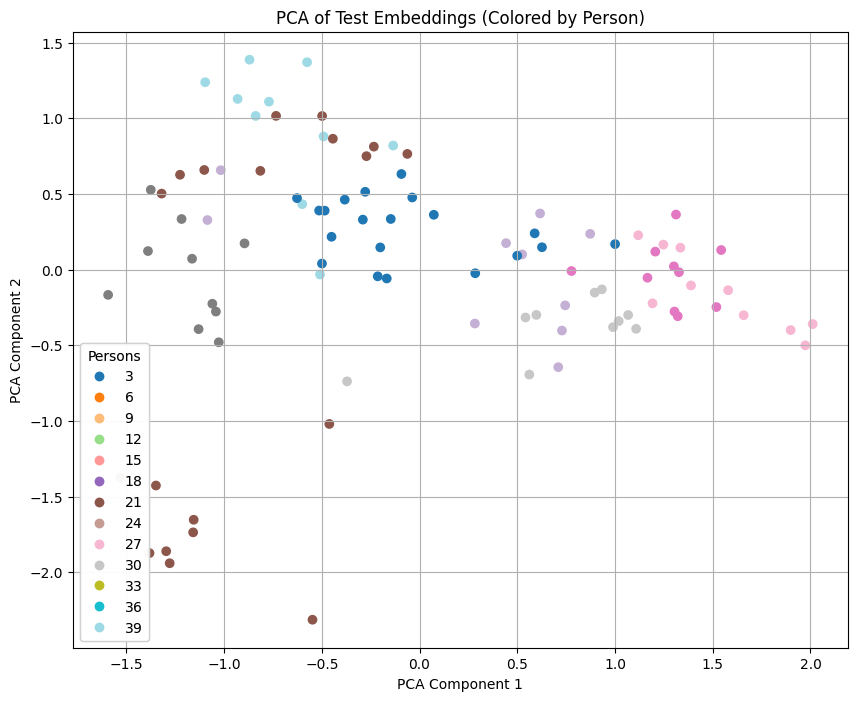

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


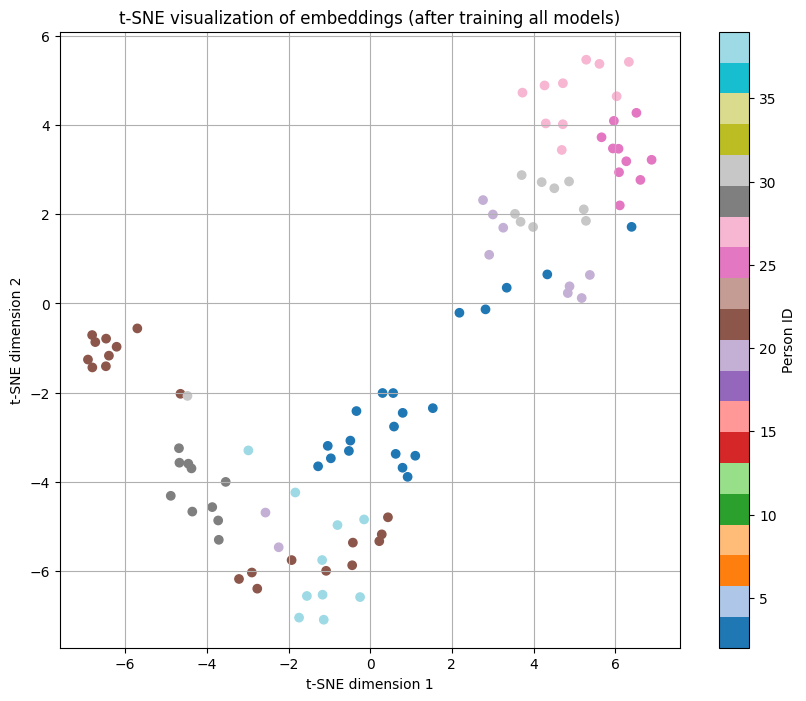

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


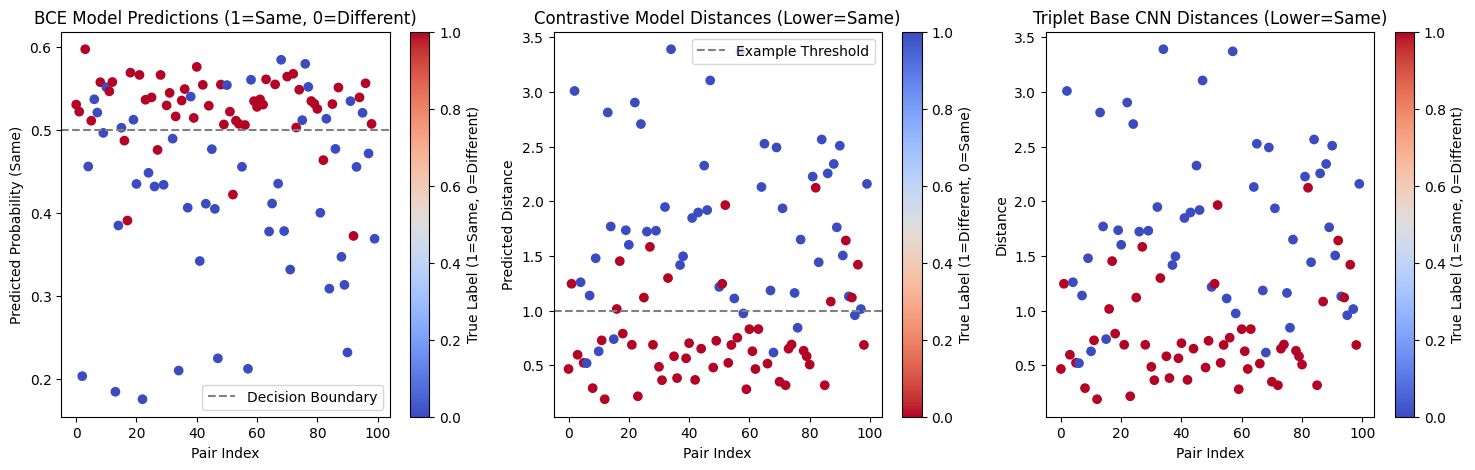

History objects for training loss are not available from the provided code structure.
To show loss curves, you would need to capture the history like: `hist_bce = model_bce.fit(...)`


In [26]:

embeddings_test = base_cnn.predict(X_test)

# Use PCA for dimensionality reduction for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
embeddings_pca = pca.fit_transform(embeddings_test)

# Visualize the embeddings with person labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=y_test, cmap='tab20')
plt.title('PCA of Test Embeddings (Colored by Person)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# Create a legend for the persons
legend1 = plt.legend(*scatter.legend_elements(),
                     loc="lower left", title="Persons")
plt.gca().add_artist(legend1)
plt.grid(True)
plt.show()

# Test with a few examples
def visualize_verification(model, X_test, y_test, base_cnn, num_examples=5):
    """Visualizes verification examples and model predictions."""
    unique_test_persons = np.unique(y_test)
    plt.figure(figsize=(15, 3 * num_examples))

    for i in range(num_examples):
        # Pick a random person
        person_id = np.random.choice(unique_test_persons)
        person_indices = np.where(y_test == person_id)[0]

        if len(person_indices) >= 2:
            # Create a positive pair
            idx1, idx2 = np.random.choice(person_indices, size=2, replace=False)
            img1_pos, img2_pos = X_test[idx1], X_test[idx2]
            label_pos = y_test[idx1]

            # Create a negative pair
            other_person_id = np.random.choice(unique_test_persons)
            while other_person_id == person_id:
                 other_person_id = np.random.choice(unique_test_persons)
            other_person_indices = np.where(y_test == other_person_id)[0]
            idx3 = np.random.choice(other_person_indices)
            img1_neg, img2_neg = X_test[idx1], X_test[idx3] # Use one image from the positive pair as anchor
            label_neg = y_test[idx3]


            # Predict with the model
            if isinstance(model.loss, tf.keras.losses.BinaryCrossentropy):
                # BCE model
                pred_pos = model.predict([np.expand_dims(img1_pos, axis=0), np.expand_dims(img2_pos, axis=0)])[0][0]
                pred_neg = model.predict([np.expand_dims(img1_neg, axis=0), np.expand_dims(img2_neg, axis=0)])[0][0]
                pos_text = f'Match Prob: {pred_pos:.2f}'
                neg_text = f'Match Prob: {pred_neg:.2f}'
                pos_decision = 'Match' if pred_pos > 0.5 else 'No Match'
                neg_decision = 'Match' if pred_neg > 0.5 else 'No Match'
                model_name = "BCE"
            elif model.loss == contrastive_loss:
                 # Contrastive model (output is distance)
                 pred_pos = model.predict([np.expand_dims(img1_pos, axis=0), np.expand_dims(img2_pos, axis=0)])[0][0]
                 pred_neg = model.predict([np.expand_dims(img1_neg, axis=0), np.expand_dims(img2_neg, axis=0)])[0][0]
                 pos_text = f'Distance: {pred_pos:.2f}'
                 neg_text = f'Distance: {pred_neg:.2f}'
                 # For contrastive loss, lower distance means same person (label 0 in contrastive)
                 # We check if distance is below a threshold (e.g., 0.5 based on model evaluation)
                 pos_decision = 'Match' if pred_pos < 0.5 else 'No Match'
                 neg_decision = 'Match' if pred_neg < 0.5 else 'No Match'
                 model_name = "Contrastive"
            elif isinstance(model, keras.Model) and isinstance(model.layers[-1], TripletLossLayer): # Check for the custom TripletLossLayer
                 # Triplet model (we calculate distances from base_cnn output)
                 emb1_pos = base_cnn.predict(np.expand_dims(img1_pos, axis=0))[0]
                 emb2_pos = base_cnn.predict(np.expand_dims(img2_pos, axis=0))[0]
                 emb2_neg = base_cnn.predict(np.expand_dims(img1_neg, axis=0))[0] # Anchor is img1_neg (which is same as img1_pos)
                 pred_pos = np.linalg.norm(emb1_pos - emb2_pos)
                 pred_neg = np.linalg.norm(emb1_pos - emb2_neg)
                 pos_text = f'Distance: {pred_pos:.2f}'
                 neg_text = f'Distance: {pred_neg:.2f}'
                 # For triplet loss, lower distance means same person
                 # We check if the positive distance is less than the negative distance
                 pos_decision = 'Match' if pred_pos < pred_neg else 'No Match' # A simplified check based on triplet goal
                 neg_decision = 'Match' if pred_neg > pred_pos else 'No Match' # A simplified check based on triplet goal (negative distance should be greater)
                 model_name = "Triplet"
            else:
                continue # Skip if the model is not recognized


            # Plot the positive pair
            plt.subplot(num_examples, 4, i*4 + 1)
            plt.imshow(img1_pos[:,:,0], cmap='gray')
            plt.title(f"Person {label_pos}")
            plt.axis('off')

            plt.subplot(num_examples, 4, i*4 + 2)
            plt.imshow(img2_pos[:,:,0], cmap='gray')
            plt.title(f"Person {label_pos}")
            plt.text(32, 70, f'{model_name}: {pos_text}\nPred: {pos_decision}',
                     horizontalalignment='center', verticalalignment='center', fontsize=10, color='green' if pos_decision == 'Match' else 'red')
            plt.axis('off')

            # Plot the negative pair
            plt.subplot(num_examples, 4, i*4 + 3)
            plt.imshow(img1_neg[:,:,0], cmap='gray')
            plt.title(f"Person {label_pos}") # Anchor image (same as img1_pos)
            plt.axis('off')


            plt.subplot(num_examples, 4, i*4 + 4)
            plt.imshow(img2_neg[:,:,0], cmap='gray')
            plt.title(f"Person {label_neg}")
            plt.text(32, 70, f'{model_name}: {neg_text}\nPred: {neg_decision}',
                     horizontalalignment='center', verticalalignment='center', fontsize=10, color='red' if neg_decision == 'Match' else 'green')
            plt.axis('off')

        else:
            print(f"Skipping person {person_id} as they have less than 2 images in the test set.")

    plt.tight_layout()
    plt.show()

# Fix: Use y_test directly as it already corresponds to X_test after the initial split
y_vis = y_test[:n_vis_samples]



embeddings = base_cnn.predict(X_vis)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
embeddings_tsne = tsne.fit_transform(embeddings)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=y_vis, cmap='tab20')
plt.title('t-SNE visualization of embeddings (after training all models)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(scatter, label='Person ID')
plt.grid(True)
plt.show()

# Visual comparison of distances for test pairs
# Sample a smaller number of pairs for visualization
n_vis_pairs = 100
X1_vis = X1_test[:n_vis_pairs]
X2_vis = X2_test[:n_vis_pairs]
y_pairs_vis = y_pairs_test[:n_vis_pairs]
y_pairs_vis_con = 1 - y_pairs_vis # For contrastive loss perspective

# Get predictions/distances from each model
preds_bce = model_bce.predict([X1_vis, X2_vis]).ravel()
dists_contrastive = model_contrastive.predict([X1_vis, X2_vis]).ravel()
# For triplet, we use the base_cnn and calculate distances manually
emb1_vis = base_cnn.predict(X1_vis)
emb2_vis = base_cnn.predict(X2_vis)
dists_triplet = np.linalg.norm(emb1_vis - emb2_vis, axis=1)

plt.figure(figsize=(18, 5))

# Plot BCE predictions
plt.subplot(1, 3, 1)
plt.scatter(range(n_vis_pairs), preds_bce, c=y_pairs_vis, cmap='coolwarm')
plt.title('BCE Model Predictions (1=Same, 0=Different)')
plt.xlabel('Pair Index')
plt.ylabel('Predicted Probability (Same)')
plt.colorbar(label='True Label (1=Same, 0=Different)')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Decision Boundary')
plt.legend()

# Plot Contrastive distances
plt.subplot(1, 3, 2)
plt.scatter(range(n_vis_pairs), dists_contrastive, c=y_pairs_vis_con, cmap='coolwarm_r') # Reverse cmap as 1=different
plt.title('Contrastive Model Distances (Lower=Same)')
plt.xlabel('Pair Index')
plt.ylabel('Predicted Distance')
plt.colorbar(label='True Label (1=Different, 0=Same)')
# Note: The decision boundary for contrastive is not fixed at 0.5 globally,
# it depends on the learned scale, but often values near 0.5 or 1 are used as thresholds.
plt.axhline(y=1.0, color='gray', linestyle='--', label='Example Threshold') # Example threshold
plt.legend()


# Plot Triplet distances (using base_cnn)
plt.subplot(1, 3, 3)
plt.scatter(range(n_vis_pairs), dists_triplet, c=y_pairs_vis, cmap='coolwarm')
plt.title('Triplet Base CNN Distances (Lower=Same)')
plt.xlabel('Pair Index')
plt.ylabel('Distance')
plt.colorbar(label='True Label (1=Same, 0=Different)')
# Triplet loss enforces d(a,p) + alpha < d(a,n). This doesn't give a direct
# threshold for d(x1, x2) pairs, but smaller distances should correspond to same identities.
# We can observe if 'same' (c=1, red) pairs tend to have smaller distances.
plt.show()

# Finally, compare loss curves (if available from fit history)
# Check if history objects exist
if 'hist_bce' in locals() and 'hist_contrastive' in locals() and 'hist_triplet' in locals():
    plt.figure(figsize=(15, 5))

    # Plot BCE Loss
    plt.subplot(1, 3, 1)
    plt.plot(hist_bce.history['loss'], label='Train Loss')
    plt.plot(hist_bce.history['val_loss'], label='Validation Loss')
    plt.title('BCE Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Contrastive Loss
    plt.subplot(1, 3, 2)
    # Access history correctly from the returned history objects
    plt.plot(hist_contrastive.history['loss'], label='Train Loss')
    plt.plot(hist_contrastive.history['val_loss'], label='Validation Loss')
    plt.title('Contrastive Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Triplet Loss
    plt.subplot(1, 3, 3)
    # Access history correctly from the returned history objects
    plt.plot(hist_triplet.history['loss'], label='Train Loss')
    plt.plot(hist_triplet.history['val_loss'], label='Validation Loss')
    plt.title('Triplet Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("History objects for training loss are not available from the provided code structure.")
    print("To show loss curves, you would need to capture the history like: `hist_bce = model_bce.fit(...)`")

In [22]:
# Prepare data for VAE (normalize to [0,1])
X_train_vae, X_test_vae = X_train, X_test  # already [0,1] float

# VAE encoder/decoder
latent_dim = 64

# Encoder
enc_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(enc_input)
x = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
# Sampling
def sample_z(args):
    mu, logvar = args
    eps = K.random_normal(shape=K.shape(mu))
    return mu + K.exp(0.5 * logvar) * eps
z = layers.Lambda(sample_z, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = keras.Model(enc_input, [z_mean, z_log_var, z], name='encoder')

# Decoder
dec_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(16*16*64, activation='relu')(dec_input)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
dec_output = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = keras.Model(dec_input, dec_output, name='decoder')


# Custom VAE Layer
class VAELayer(keras.layers.Layer):
    def __init__(self, encoder, decoder, reconstruction_loss_fn=keras.losses.binary_crossentropy, **kwargs):
        super(VAELayer, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_fn = reconstruction_loss_fn

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # VAE loss (KL + reconstruction)
        # Flatten y_true and y_pred while preserving the batch dimension
        y_true_flat = K.batch_flatten(inputs)
        y_pred_flat = K.batch_flatten(reconstruction)

        # Calculate reconstruction loss per element using the specified loss function
        reconstruction_loss = self.reconstruction_loss_fn(y_true_flat, y_pred_flat)
        # Sum reconstruction loss over the flattened dimensions (axis 1 after batch_flatten)
        reconstruction_loss = K.sum(reconstruction_loss, axis=-1)

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        # Total VAE loss is the mean over the batch
        vae_loss = K.mean(reconstruction_loss + kl_loss)

        self.add_loss(vae_loss) # Add VAE loss to the layer's losses

        return reconstruction # Output the reconstructed image

    def compute_output_shape(self, input_shape):
        return input_shape

# Redefine the VAE model and train function to use the updated VAELayer
# (This part will be moved to the next cell to keep it separate for comparison)

Training VAE with BCE reconstruction loss...
Epoch 1/10
10/10 - 9s - 864ms/step - loss: 21.8613 - val_loss: 21.2398
Epoch 2/10
10/10 - 0s - 20ms/step - loss: 21.3631 - val_loss: 21.0869
Epoch 3/10
10/10 - 0s - 18ms/step - loss: 21.2278 - val_loss: 20.9164
Epoch 4/10
10/10 - 0s - 17ms/step - loss: 21.0949 - val_loss: 20.8125
Epoch 5/10
10/10 - 0s - 17ms/step - loss: 21.0341 - val_loss: 20.7978
Epoch 6/10
10/10 - 0s - 30ms/step - loss: 21.0227 - val_loss: 20.8068
Epoch 7/10
10/10 - 0s - 17ms/step - loss: 21.0260 - val_loss: 20.7705
Epoch 8/10
10/10 - 0s - 29ms/step - loss: 20.9975 - val_loss: 20.7906
Epoch 9/10
10/10 - 0s - 16ms/step - loss: 21.0030 - val_loss: 20.7683
Epoch 10/10
10/10 - 0s - 31ms/step - loss: 20.9971 - val_loss: 20.7683
Training VAE with MSE reconstruction loss...
Epoch 1/10
10/10 - 10s - 968ms/step - loss: 0.6999 - val_loss: 0.6285
Epoch 2/10
10/10 - 4s - 380ms/step - loss: 0.6980 - val_loss: 0.6238
Epoch 3/10
10/10 - 0s - 28ms/step - loss: 0.6985 - val_loss: 0.6267
E

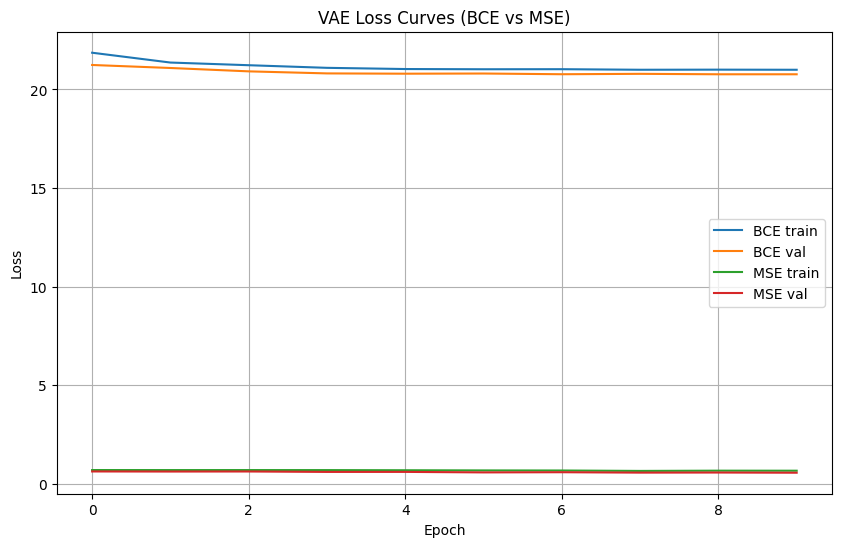

In [23]:
# Helper to compile and fit VAE with different reconstruction losses
def train_vae(loss_name):
    # Re-define the VAE model with the updated VAELayer
    vae_input = layers.Input(shape=input_shape, name='vae_input_'+loss_name.lower())
    if loss_name == 'BCE':
        vae_layer = VAELayer(encoder, decoder, reconstruction_loss_fn=keras.losses.binary_crossentropy, name='vae_layer_bce')(vae_input)
    elif loss_name == 'MSE':
        vae_layer = VAELayer(encoder, decoder, reconstruction_loss_fn=keras.losses.mse, name='vae_layer_mse')(vae_input)
    else:
        raise ValueError(f"Unknown loss name: {loss_name}")

    vae = keras.Model(vae_input, vae_layer, name='vae_'+loss_name.lower())

    # Compile the VAE model (loss is added via the custom layer)
    vae.compile(optimizer='adam')

    # Train the VAE
    print(f"Training VAE with {loss_name} reconstruction loss...")
    history = vae.fit(X_train_vae, X_train_vae, epochs=10, batch_size=32,
                      validation_data=(X_test_vae, X_test_vae), verbose=2)
    return vae, history

# Train VAEs with BCE and MSE reconstruction losses
vae_bce, hist_bce = train_vae('BCE')
vae_mse, hist_mse = train_vae('MSE')

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(hist_bce.history['loss'], label='BCE train')
plt.plot(hist_bce.history['val_loss'], label='BCE val')
plt.plot(hist_mse.history['loss'], label='MSE train')
plt.plot(hist_mse.history['val_loss'], label='MSE val')
plt.title("VAE Loss Curves (BCE vs MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


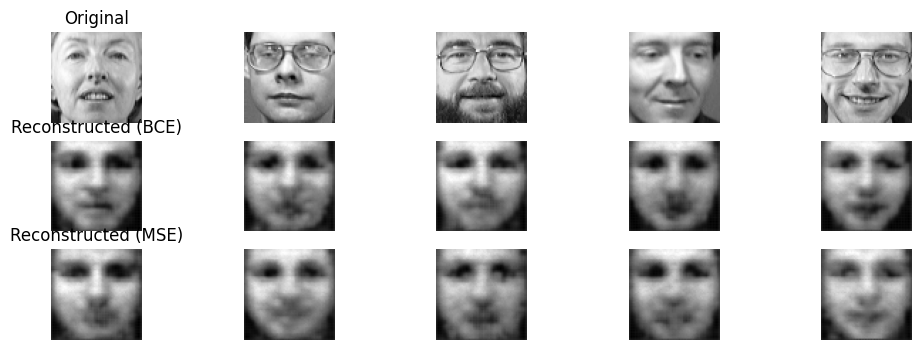

In [24]:
# Show original and reconstructed faces side by side
n = 5
idx = np.random.choice(len(X_test_vae), n, replace=False)
orig = X_test_vae[idx]
rec_bce = vae_bce.predict(orig)
rec_mse = vae_mse.predict(orig)

plt.figure(figsize=(12,4))
for i in range(n):
    # original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(orig[i].squeeze(), cmap='gray'); plt.axis('off')
    if i==0: ax.set_title('Original')
    # BCE recon
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(rec_bce[i].squeeze(), cmap='gray'); plt.axis('off')
    if i==0: ax.set_title('Reconstructed (BCE)')
    # MSE recon
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(rec_mse[i].squeeze(), cmap='gray'); plt.axis('off')
    if i==0: ax.set_title('Reconstructed (MSE)')
plt.show()
